In [2]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from fastai.vision.all import *
import torch.nn as nn
import torch.nn.functional as F

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainTransform  = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.1307,), (0.3081,))])
trainset = tv.datasets.MNIST(root='./data',  train=True,download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=False, num_workers=4)
testset = tv.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

In [61]:
# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

In [62]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [109]:
num_epochs = 15

### let's dive into BCE(binary cross-entropy) simple example

In [56]:
input = torch.randn(3, 2, requires_grad=True)
target = torch.rand(3, 2, requires_grad=False)
loss = F.binary_cross_entropy(torch.sigmoid(input), target)
loss.backward()
# print(f"input {input} \n target {target} \n loss {loss}")
print(f"loss {loss}")

loss 0.966417133808136


In [57]:
omega = 1
predictions = torch.sigmoid(input)
# Calculate binary cross-entropy loss manually
loss = -omega * (target * torch.log(predictions) + (1 - target) * torch.log(1 - predictions))

# Mean loss
mean_loss = torch.mean(loss)
print(mean_loss)

tensor(0.9664, grad_fn=<MeanBackward0>)


In [58]:
N = input.shape[0]
# omega = 0.5
loss = 0
preds = torch.sigmoid(input)
for pt_i in range(N):
    y_n = target[pt_i]
    x_n = preds[pt_i]
    pt_i_loss = -omega * (y_n*torch.log(x_n)  + (1 - y_n)*torch.log(1 - x_n))
    loss += pt_i_loss

# print('loss: ', loss)
mean_loss = torch.mean(loss, dim=0, keepdim=True)
print('loss mean ', mean_loss/N)

loss mean  tensor([0.9664], grad_fn=<DivBackward0>)


### Main trainig loop

In [110]:
# Start training
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(dataloader):
        # Forward pass
        x = x.to(device).view(-1, 784)
        # x = x.to(device)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # if (i+1) % 200 == 0:
        #     print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
        #            .format(epoch+1, num_epochs, i+1, len(dataloader), reconst_loss.item(), kl_div.item()))
    print ("Epoch[{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, reconst_loss.item(), kl_div.item()))


/home/ilua/miniconda3/envs/py39cuda116/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/15], Reconst Loss: -1092608.5000, KL Div: 3858.2903
Epoch[2/15], Reconst Loss: -1095701.1250, KL Div: 3823.0483
Epoch[3/15], Reconst Loss: -1099263.0000, KL Div: 3770.2646
Epoch[4/15], Reconst Loss: -1098079.5000, KL Div: 3709.2632
Epoch[5/15], Reconst Loss: -1101372.3750, KL Div: 3693.3950
Epoch[6/15], Reconst Loss: -1104072.6250, KL Div: 3650.2349
Epoch[7/15], Reconst Loss: -1105262.6250, KL Div: 3625.8472
Epoch[8/15], Reconst Loss: -1105792.5000, KL Div: 3594.6692
Epoch[9/15], Reconst Loss: -1108535.1250, KL Div: 3556.2427
Epoch[10/15], Reconst Loss: -1110443.3750, KL Div: 3555.4917
Epoch[11/15], Reconst Loss: -1112207.7500, KL Div: 3509.7607
Epoch[12/15], Reconst Loss: -1115444.1250, KL Div: 3501.4019
Epoch[13/15], Reconst Loss: -1114905.8750, KL Div: 3455.5715
Epoch[14/15], Reconst Loss: -1116851.2500, KL Div: 3447.5994
Epoch[15/15], Reconst Loss: -1119424.5000, KL Div: 3422.6023


In [111]:
with torch.no_grad():
    z = torch.randn(32, 20).to(device)
    out = model.decode(z).view(-1, 1, 28, 28)

    out2, _, _ = model(x)
    out2 = out2.view(-1, 1, 28, 28)

    out3 = x.view(-1, 1, 28, 28)

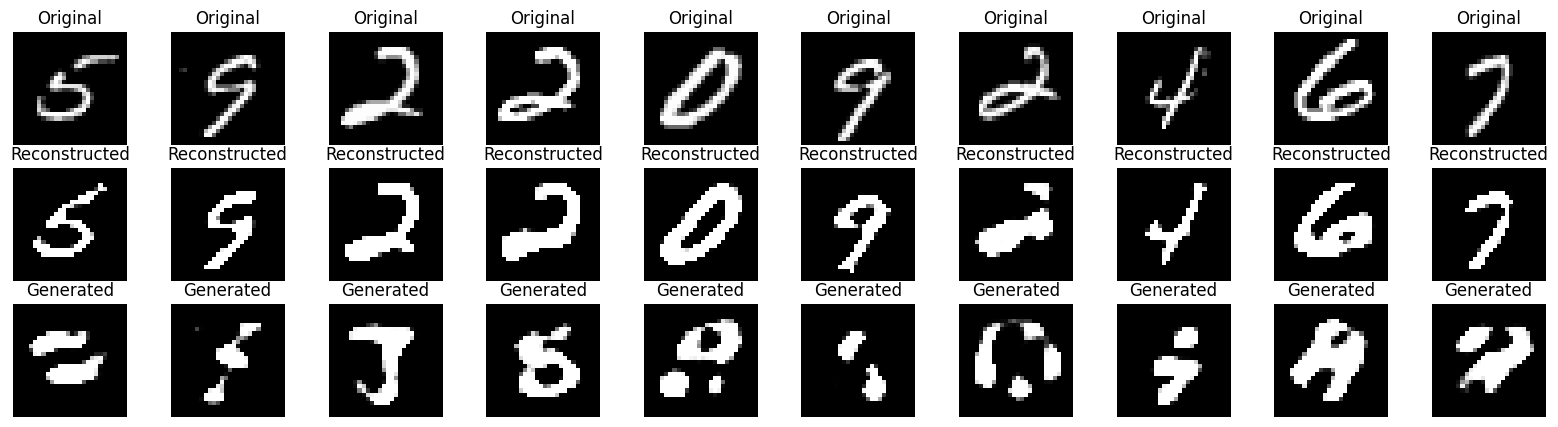

In [112]:
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

num_images = 10
fig, axes = plt.subplots(3, num_images, figsize=(num_images * 2, 5))
for i in range(num_images):

    # inputs
    axes[0, i].imshow(out3[i].squeeze().cpu().numpy(), cmap='gray')
    axes[0, i].set_title('Original')
    axes[0, i].axis('off')

    # outputs
    axes[1, i].imshow(out2[i].squeeze().cpu().numpy(), cmap='gray')
    axes[1, i].set_title('Reconstructed')
    axes[1, i].axis('off')

    # rand sample
    axes[2, i].imshow(out[i].squeeze().cpu().numpy(), cmap='gray')
    axes[2, i].set_title('Generated')
    axes[2, i].axis('off')



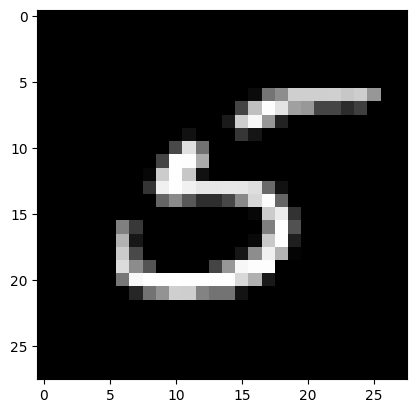

In [121]:
inp = x.cpu().view(-1, 1, 28, 28)
img = inp[0].squeeze()

plt.imshow(img, cmap='gray')
plt.show()

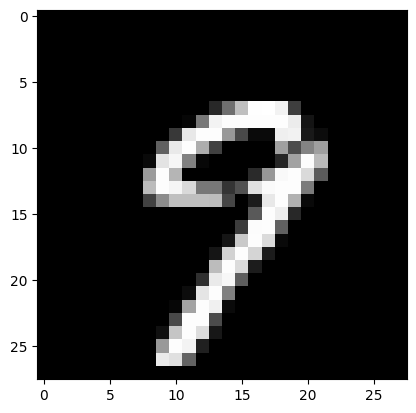

In [122]:
img2 = inp[5].squeeze()

plt.imshow(img2, cmap='gray')
plt.show()

In [ ]:
steps = 10
num_images = 10
fig, axes = plt.subplots(1, num_images, figsize=(steps * 2, 5))
for i in range(steps):

    # inputs
    axes[0, i].imshow(out3[i].squeeze().cpu().numpy(), cmap='gray')
    axes[0, i].set_title('Original')
    axes[0, i].axis('off')



In [123]:
def interpolate_and_plot(vae, img1, img2, steps=10):
    # Encode the two images
    mu1, log_var1 = vae.encode(img1)
    z1 = vae.reparameterize(mu1, log_var1)

    mu2, log_var2 = vae.encode(img2)
    z2 = vae.reparameterize(mu2, log_var2)

    # Interpolate between z1 and z2
    interpolated_images = []
    for alpha in torch.linspace(0, 1, steps):
        z = (1 - alpha) * z1 + alpha * z2
        img_recon = vae.decode(z)
        interpolated_images.append(img_recon.detach().cpu().numpy().reshape(28, 28))  # Assuming 28x28 image size

    # Plotting
    fig, axs = plt.subplots(1, steps, figsize=(steps * 2, 2))
    for i, img in enumerate(interpolated_images):
        axs[i].imshow(img, cmap='gray')
        axs[i].axis('off')
    plt.show()

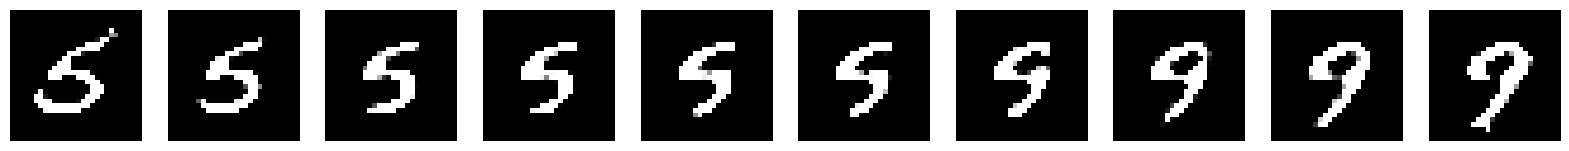

In [125]:
image1 = x.cpu()[0]
image2 = x.cpu()[5]
modelcpu = model.to('cpu')

interpolate_and_plot(model, image1, image2)